# Import data and pre-process

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

df = pd.read_csv('hp_data_dre.csv')
df = df.rename(columns=lambda x: x.replace(' ', ''))
df = df.rename(columns=lambda x: x.replace('HP_ambient_temp', 'T_amb'))
df = df.rename(columns=lambda x: x.replace('[C]', ''))
df = df.drop(['HP_on_off', 'Unnamed:15', 'Unnamed:16', 'HP_AC_Voltage', 'HP_AC_Current'], axis=1)

renaming = {
    'HP_mode:0=cooling,1=heating': 'HP_mode',
    'HP_setpoint': 'T_setpoint',
    'HP_inlet_temp': 'T_in',
    'HP_outlet_temp': 'T_out',
    'HP_compressor_freq[Hz]': 'f_comp',
    'Heat_xfer_rate[W]': 'Q_HP',
    'HP_Power[W]':'W_HP',
    'HP_in_flow[L/min]': 'm_HP'
}
df = df.rename(columns=renaming)

df['COP'] = df.Q_HP / df.W_HP
df['COP'] = df['COP'].round(2)

display(df)

,timestamp,HP_mode,T_setpoint,T_in,T_out,T_amb1,T_amb2,T_amb3,m_HP,f_comp,W_HP,Q_HP,COP
0,2024-07-17 9:55:30,0,40,28,28,15,13.3,12.8,23.1,0,0,0.000000,NaN
1,2024-07-17 9:55:32,0,40,27,28,15,13.1,12.5,23.2,0,0,1615.111711,inf
2,2024-07-17 9:55:35,0,40,27,28,15,13.1,12.6,23.3,0,0,1624.680103,inf
3,2024-07-17 9:55:37,0,40,27,28,15,13.0,12.5,23.2,0,0,1618.839506,inf
4,2024-07-17 9:55:40,0,40,27,28,15,12.9,12.5,23.2,0,0,1619.897886,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,2024-07-17 15:41:01,0,55,28,28,14,12.4,12.4,27.8,0,0,0.000000,NaN
7479,2024-07-17 15:41:03,0,55,28,28,14,12.3,12.5,27.3,0,0,0.000000,NaN
7480,2024-07-17 15:41:06,0,55,28,28,14,12.3,12.4,28.0,0,0,0.000000,NaN
7481,2024-07-17 15:41:09,0,55,28,28,14,12.3,12.2,27.8,0,0,0.000000,NaN


### Split data by mode (heating or cooling)

In [2]:
df_cooling = df[df.HP_mode == 0]
df_cooling = df_cooling[df_cooling.Q_HP<=0]
df_cooling['COP'] = np.abs(df_cooling['COP'])
df_cooling = df_cooling.reset_index()

df_heating = df[df.HP_mode == 1]
df_heating = df_heating[df_heating.Q_HP>=0]
df_heating = df_heating[df_heating.COP>=0]
df_heating = df_heating.reset_index()

print(f'Heating: {len(df_heating)}\nCooling: {len(df_cooling)}')

Heating: 3648
Cooling: 2174


# Regression

In [3]:
from scipy.optimize import curve_fit

def model(X,a,b1,b2,b3,b4,b5,c1,c2,c3,c4,c5,d1,d2,d3,d4,d5,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,g):
    x1, x2, x3, x4, x5 = X
    approx = (a 
              + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 
              + c1*x1**2 + c2*x2**2 + c3*x3**2 + c4*x4**2 + c5*x5**2
              + d1*x1**3 + d2*x2**3 + d3*x3**3 + d4*x4**3 + d5*x5**3
              + e1*x1*x2 + e2*x1*x3 + e3*x1*x4 + e4*x1*x5 + e5*x2*x3 + e6*x2*x4 + e7*x2*x5 + e8*x3*x4 + e9*x3*x5 + e10*x4*x5
              + f1*x1**2*x2 + f2*x1**2*x3 + f3*x1**2*x4 + f4*x1**2*x5 + f5*x2**2*x3 + f6*x2**2*x4 + f7*x2**2*x5 + f8*x3**2*x4 + f9*x3**2*x5 + f10*x4**2*x5
              + g*x1*x2*x3*x4*x5)
    return approx

print('*'*25 + '\nHEATING MODE\n' + '*'*25)

x_t_out = np.array(list(df_heating.T_out))
x_f_comp = np.array(list(df_heating.f_comp))
x_t_amb1 = np.array(list(df_heating.T_amb1))
x_t_amb2 = np.array(list(df_heating.T_amb2))
x_t_amb3 = np.array(list(df_heating.T_amb3))
X = np.vstack((x_t_out, x_f_comp, x_t_amb1, x_t_amb2, x_t_amb3))
y_q_hp = np.array(list(df_heating.Q_HP))
y_w_hp = np.array(list(df_heating.W_HP))

popt_qhp, pcov_qhp = curve_fit(model, X, y_q_hp)
popt_whp, pcov_whp = curve_fit(model, X, y_w_hp)
df_heating['Q_HP_advanced'] = model((x_t_out, x_f_comp, x_t_amb1, x_t_amb2, x_t_amb3), *popt_qhp)
df_heating['W_HP_advanced'] = model((x_t_out, x_f_comp, x_t_amb1, x_t_amb2, x_t_amb3), *popt_whp)
print(f"\nQ_HP - coefficients:\n{[round(x,2) for x in popt_qhp]}\n")
print(f"W_HP - coefficients:\n{[round(x,2) for x in popt_whp]}\n")

print('*'*25 + '\nCOOLING MODE\n' + '*'*25)

x_t_out = np.array(list(df_cooling.T_out))
x_f_comp = np.array(list(df_cooling.f_comp))
x_t_amb1 = np.array(list(df_cooling.T_amb1))
x_t_amb2 = np.array(list(df_cooling.T_amb2))
x_t_amb3 = np.array(list(df_cooling.T_amb3))
X = np.vstack((x_t_out, x_f_comp, x_t_amb1, x_t_amb2, x_t_amb3))
y_q_hp = np.array(list(df_cooling.Q_HP))
y_w_hp = np.array(list(df_cooling.W_HP))

popt_qhp, pcov_qhp = curve_fit(model, X, y_q_hp)
popt_whp, pcov_whp = curve_fit(model, X, y_w_hp)
df_cooling['Q_HP_advanced'] = model((x_t_out, x_f_comp, x_t_amb1, x_t_amb2, x_t_amb3), *popt_qhp)
df_cooling['W_HP_advanced'] = model((x_t_out, x_f_comp, x_t_amb1, x_t_amb2, x_t_amb3), *popt_whp)
print(f"\nQ_HP - coefficients:\n{[round(x,2) for x in popt_qhp]}\n")
print(f"W_HP - coefficients:\n{[round(x,2) for x in popt_whp]}")

*************************
HEATING MODE
*************************

Q_HP - coefficients:
[203560.86, 3067.32, -1675.68, -19614.84, -27940.21, 789.05, -99.52, 0.86, 1848.52, -0.77, -1141.02, 1.15, -0.18, -41.39, 65.62, 22.05, 31.5, 67.4, -40.49, 60.84, -25.2, -1.65, 106.26, -889.0, -1605.44, 4821.27, -0.28, -0.5, -0.3, -1.12, 0.79, 0.9, -0.87, 18.67, 34.9, -164.41, -0.0]

W_HP - coefficients:
[-2435.68, 159.0, 266.63, 1573.84, -1642.14, -827.85, -2.36, -3.32, -93.04, 335.81, 21.82, 0.01, -0.02, 1.92, -12.85, -0.6, 1.46, -14.76, -8.04, 17.66, -9.12, -10.32, 2.45, -28.36, 130.44, -243.17, -0.0, 0.17, 0.05, -0.18, 0.16, 0.21, -0.11, 0.24, -2.56, 9.9, 0.0]

*************************
COOLING MODE
*************************

Q_HP - coefficients:
[-246478.77, -3639.56, -6419.69, -12512.68, 125356.71, -37547.85, 30.6, 154.5, 175.86, -17183.67, -1476.46, 0.68, -0.39, 16.44, 571.6, 26.67, -94.28, -110.98, 538.05, 88.78, -203.49, 1064.28, -270.57, 2506.99, -271.54, 8799.1, 1.58, 1.03, -9.27, -0.26, 2

In [4]:
def rmse(a, b):
    a, b = list(a), list(b)
    square_error = [(a[i]-b[i])**2 for i in range(len(a))]
    return round(np.sqrt(sum(square_error)/len(square_error))/1000,1)

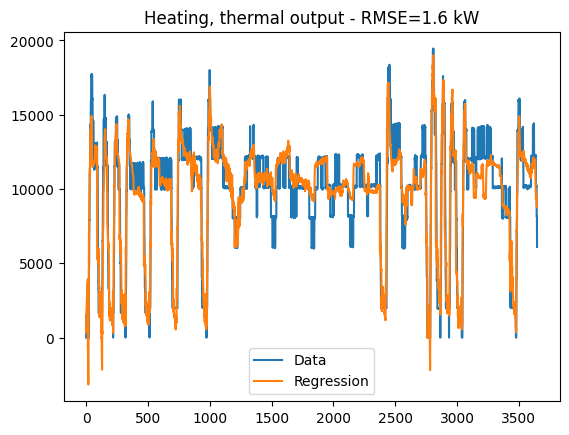

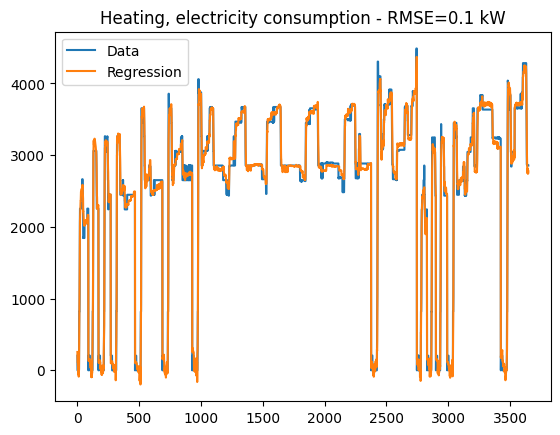

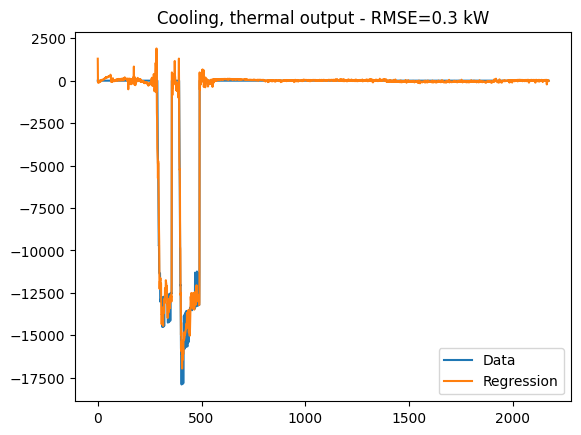

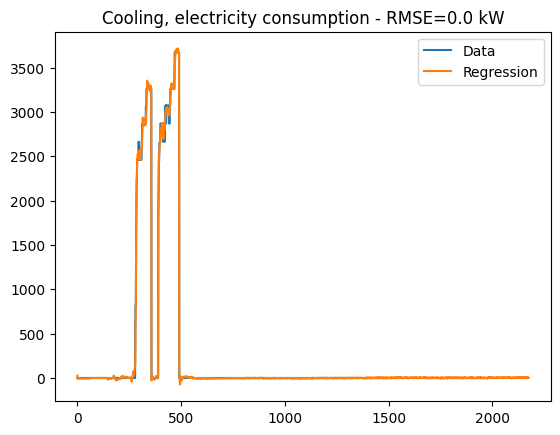

In [5]:
plt.plot(df_heating.Q_HP, label='Data')
plt.plot(df_heating.Q_HP_advanced, label='Regression')
plt.title(f'Heating, thermal output - RMSE={rmse(df_heating.Q_HP, df_heating.Q_HP_advanced)} kW')
plt.legend()
plt.show()

plt.plot(df_heating.W_HP, label='Data')
plt.plot(df_heating.W_HP_advanced, label='Regression')
plt.title(f'Heating, electricity consumption - RMSE={rmse(df_heating.W_HP, df_heating.W_HP_advanced)} kW')
plt.legend()
plt.show()

plt.plot(df_cooling.Q_HP, label='Data')
plt.plot(df_cooling.Q_HP_advanced, label='Regression')
plt.title(f'Cooling, thermal output - RMSE={rmse(df_cooling.Q_HP, df_cooling.Q_HP_advanced)} kW')
plt.legend()
plt.show()

plt.plot(df_cooling.W_HP, label='Data')
plt.plot(df_cooling.W_HP_advanced, label='Regression')
plt.title(f'Cooling, electricity consumption - RMSE={rmse(df_cooling.W_HP, df_cooling.W_HP_advanced)} kW')
plt.legend()
plt.show()